### Classification Network - Second Level - Prediction - OoD kNN: 

In [1]:
!pip install progressbar2

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import pickle
import numpy as np

import math

from numpy import linalg

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from scipy.spatial import distance

import matplotlib.pyplot as plt
from progressbar import ProgressBar

C:\Users\dlezo\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Calculate the distances in order to identify lambda parameter

In [3]:
def cosine_similarity(K, z):
    # Normalize the rows of K and vector z
    K_norm = np.linalg.norm(K, axis=1, keepdims=True)  # Row-wise norms
    z_norm = np.linalg.norm(z)  # Norm of vector z
    # Compute cosine similarity: dot product divided by norms
    similarity = (K @ z.T) / (K_norm.flatten() * z_norm)
    return similarity

ks = [5, 10, 20, 35, 50, 75, 100, 150, 200, 500, 1000, 2500, 5000, 10000, 20000, 30000]

def calculate_kNN(seen_z, unseen_z, filename, nxc, comp='cos'):
    unseen_z = unseen_z.drop(columns=[c for c in unseen_z.columns if c.startswith('kNN')])
    normsK = {}
    for k in ks:
        normsK[str(k)] = np.ndarray(len(unseen_z))
    seenz = seen_z[nxc]#.reset_index(drop=True)
    unseenz = unseen_z[nxc]#.reset_index(drop=True)
    index = 0
    mod = len(unseenz)//1000+1
    bar = ProgressBar(max_value=1000)
    for _, z in unseenz.iterrows():
        if comp == 'norm':
            norms = np.sort(linalg.norm(seenz.sub(z), axis=1))
        if comp == 'cos':
            norms = np.sort(cosine_similarity(seenz, z))
        if comp == 'dot':
            norms = np.sort(seenz @ z.T)
        for k in ks:
            normsK[str(k)][index] = norms[k]
        if index%mod == 0:
            bar.next()
        index += 1
    bar.finish()
    for k in ks:
        kNN = 'kNN-'+str(k)
        unseen_z[kNN] = normsK[str(k)]
    if not filename == '': 
        unseen_z.to_csv(filename)
    return unseen_z.fillna(1.0)

def plot(suz, kind='density', all=False):
    plt.rcParams['figure.dpi'] = 300
    if all:
        f, axes = plt.subplots(16, 1, figsize=(30, 90))
        for idx, k in enumerate(ks):
            axes[idx].set_title('kNN-'+str(k))
        for z in suz:
            for idx, k in enumerate(ks):
                kNN = 'kNN-'+str(k)
                z[kNN].plot(kind=kind, ax=axes[idx])
    else:
        f, axes = plt.subplots(3, 1, figsize=(30, 20))
        axes[0].set_title("kNN-10")
        axes[1].set_title("kNN-100")
        axes[2].set_title("kNN-20000")
        for z in suz:
            z['kNN-10'].plot(kind=kind, ax=axes[0])
            z['kNN-100'].plot(kind=kind, ax=axes[1])
            z['kNN-20000'].plot(kind=kind, ax=axes[2])
    plt.show()

def roc(y_values, y_pred, column):
    y_pred_fit = y_pred[column].values #MinMaxScaler().fit_transform(y_pred.reshape(-1,1))
    fpr, tpr, thresholds = roc_curve(y_values, y_pred_fit)
    try:
        roc_auc = roc_auc_score(y_values, y_pred_fit)
    except:
        roc_auc = 1.0
    plt.rcParams['figure.dpi'] = 300
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{column} ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # Annotate thresholds at selected points
    points_to_annotate = np.linspace(0, len(thresholds) - 1, 10, dtype=int)
    for i in points_to_annotate:
        plt.annotate(f'{thresholds[i]:.4f}', xy=(fpr[i], tpr[i]), xytext=(fpr[i]+0.02, tpr[i]-0.02),
                     arrowprops=dict(arrowstyle='->', color='gray'), fontsize=9)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{column} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

def prc(y_values, y_pred):
    y_pred_fit = y_pred #MinMaxScaler().fit_transform(y_pred.reshape(-1,1))
    precision, recall, thresholds = precision_recall_curve(y_values, y_pred_fit)
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2)
    # Annotate thresholds at selected points
    points_to_annotate = np.linspace(0, len(thresholds) - 1, 10, dtype=int)
    for i in points_to_annotate:
        plt.annotate(f'{thresholds[i]:.4f}', xy=(recall[i], precision[i]), xytext=(recall[i]-0.05, precision[i]-0.05),
                     arrowprops=dict(arrowstyle='->', color='gray'), fontsize=9)
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (Positive Predictive Value)')
    plt.title('Precision-Recall Curve with Threshold Values')
    plt.grid(alpha=0.3)
    plt.show()


#### Load the dataset

In [4]:
seen = pd.read_csv('./Data/C56_71_TWOSIDES_seen.csv')
unseen = pd.read_csv('./Data/C56_71_TWOSIDES_unseen.csv')
print('seen:  ', seen.shape)
print('unseen:', unseen.shape)

seen:   (155137, 108)
unseen: (103560, 57)


#### Add column to indicate if the data is in distribution or not

In [5]:
seen['InD'] = 1.0
unseen['InD'] = 0.0
unseen.loc[unseen['class_00'] > 0.0, 'InD'] = 1.0    

In [6]:
unseen.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,class_00,class_18,class_45,InD
0,1.000000e+00,2.815398e-21,6.358751e-20,4.384631e-27,1.938304e-19,9.623365e-24,2.462681e-19,2.623977e-23,5.995489e-24,1.291265e-23,...,4.456491e-23,2.619968e-29,5.300058e-21,1.233712e-19,6.783538e-20,1.313662e-25,1.0,0.0,0.0,1.0
1,4.583039e-10,9.998994e-01,9.999807e-01,8.784420e-01,1.000000e+00,8.932958e-01,1.000000e+00,9.930088e-01,9.943914e-01,9.866188e-01,...,8.264329e-01,5.706163e-01,7.583323e-01,9.953315e-01,1.000000e+00,9.913942e-01,0.0,1.0,1.0,0.0
2,9.999790e-01,5.548874e-07,1.736640e-06,1.698929e-09,2.270942e-06,4.661000e-08,2.724757e-06,7.788381e-08,1.936822e-08,3.752763e-08,...,9.131123e-08,3.464327e-10,2.992620e-07,1.560722e-06,1.736157e-06,6.577111e-09,1.0,0.0,0.0,1.0
3,1.000000e+00,8.504946e-15,1.515249e-13,9.478777e-20,3.005128e-13,1.061210e-16,5.190206e-13,2.059991e-16,9.565930e-18,3.244542e-17,...,2.931358e-16,8.740254e-21,3.744373e-14,1.122225e-13,1.669278e-13,3.077851e-18,1.0,0.0,0.0,1.0
4,1.000000e+00,2.192595e-26,7.933947e-25,2.055319e-33,4.130046e-24,2.796804e-29,5.084289e-24,1.265693e-28,5.467337e-30,2.080931e-29,...,1.627241e-28,7.683850e-36,1.268503e-25,2.898632e-24,1.451664e-24,1.820566e-31,1.0,0.0,0.0,1.0


#### Normalize data with the L2 norm

In [7]:
xc = [
     '0',  '1',  '2',  '3',  '4',  '5',  '6',  '7',  '8',  '9', 
    '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
    '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', 
    '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 
    '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 
    '50', '51', '52', '53'
     ]
nxc = [
     'n0',  'n1',  'n2',  'n3',  'n4',  'n5',  'n6',  'n7',  'n8',  'n9', 
    'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 
    'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29', 
    'n30', 'n31', 'n32', 'n33', 'n34', 'n35', 'n36', 'n37', 'n38', 'n39', 
    'n40', 'n41', 'n42', 'n43', 'n44', 'n45', 'n46', 'n47', 'n48', 'n49', 
    'n50', 'n51', 'n52', 'n53'
      ]

seen_z = seen.copy()
norm = seen_z[xc].apply(linalg.norm, axis=1)
seen_z['norm'] = norm
norm = seen_z[xc].apply(lambda x: x/seen_z['norm'])
seen_z[nxc] = norm[xc]

unseen_z = unseen.copy()
norm = unseen_z[xc].apply(linalg.norm, axis=1)
unseen_z['norm'] = norm
norm = unseen_z[xc].apply(lambda x: x/unseen_z['norm'])
unseen_z[nxc] = norm[xc]
seen_z

,0,1,2,3,4,5,6,7,8,9,...,n44,n45,n46,n47,n48,n49,n50,n51,n52,n53
0,1.000000e+00,6.248636e-15,8.891887e-14,8.388986e-21,2.143980e-13,2.939452e-17,3.113113e-13,1.525510e-16,3.763144e-18,1.964172e-17,...,6.559005e-14,4.569553e-14,1.885307e-15,1.558835e-13,4.352274e-17,1.564538e-21,6.581496e-15,7.028576e-14,1.327974e-13,4.312506e-19
1,6.259054e-03,5.455988e-01,8.316159e-01,1.556831e-02,6.044013e-01,1.751754e-01,8.052470e-01,7.530206e-02,1.370633e-02,2.754718e-02,...,1.308571e-01,2.284412e-01,2.087092e-02,2.120185e-01,1.655700e-01,6.506737e-03,2.060871e-02,1.497054e-01,1.726658e-01,1.854534e-03
2,1.000000e+00,2.489635e-11,7.572527e-11,1.846269e-15,2.013053e-10,2.993161e-13,1.808969e-10,1.951775e-12,3.370806e-13,6.563878e-13,...,1.126884e-10,5.501796e-11,3.129510e-12,1.060717e-10,4.677411e-13,2.002569e-16,3.360588e-12,1.051620e-10,1.116899e-10,2.859270e-14
3,1.000000e+00,1.713499e-13,1.312378e-12,6.032831e-19,3.915362e-12,1.131710e-15,5.384451e-12,2.331678e-15,1.647061e-16,5.140554e-16,...,1.121075e-12,8.910754e-13,4.356217e-14,2.242728e-12,4.532357e-15,8.215193e-20,1.213732e-13,1.016825e-12,1.875504e-12,2.717294e-17
4,5.353331e-04,8.048165e-01,9.528591e-01,1.699650e-01,9.972506e-01,1.811222e-01,9.964830e-01,6.150748e-01,2.829334e-01,3.643553e-01,...,1.837837e-01,1.703841e-01,4.652763e-02,1.758130e-01,1.336191e-02,1.073736e-02,1.686548e-02,1.174964e-01,1.844659e-01,4.659130e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155132,9.948282e-01,5.134299e-04,1.158439e-03,2.817367e-06,1.600236e-03,5.653707e-05,1.793392e-03,1.112630e-04,2.163182e-05,5.048900e-05,...,1.028078e-03,8.762624e-04,1.737305e-04,1.332831e-03,6.373048e-05,1.969175e-06,2.086465e-04,7.701642e-04,1.339771e-03,1.494778e-05
155133,7.458865e-05,8.382397e-01,9.710732e-01,5.918161e-02,9.984146e-01,1.584331e-01,9.987572e-01,4.979841e-01,1.138714e-01,2.699476e-01,...,1.796073e-01,1.769737e-01,4.543732e-02,1.761118e-01,1.329452e-02,5.757618e-03,1.601314e-02,1.279009e-01,1.800890e-01,4.674634e-02
155134,7.581404e-05,9.663745e-01,9.340098e-01,1.748229e-01,9.987280e-01,2.723095e-01,9.996678e-01,4.188244e-01,8.194007e-01,8.474261e-01,...,1.620429e-01,1.624893e-01,7.224644e-02,1.617418e-01,1.230315e-01,9.909820e-03,3.563882e-02,1.289561e-01,1.626508e-01,1.250913e-01
155135,9.999999e-01,2.201795e-10,9.948171e-10,1.163676e-13,1.799341e-09,5.853758e-12,2.176331e-09,1.106277e-11,6.215884e-12,8.110722e-12,...,8.666645e-10,8.317147e-10,8.501235e-11,1.435255e-09,2.449280e-11,1.363085e-14,1.571219e-10,8.473217e-10,1.096986e-09,6.160233e-13


#### Calculate kNNs over a Base of only the Negative samples, sample the input due to n^2 complexity of algorithm

In [8]:
random_seed = 1 #42 #73 # 71

uz = calculate_kNN(seen_z[seen_z['class_00'] == 1.0], unseen_z.sample(2000, random_state=random_seed, ignore_index=True), 
                   '', nxc, 
                  )
seen_z_sample = calculate_kNN(seen_z[seen_z['class_00'] == 1.0], 
                              seen_z.sample(len(uz), random_state=random_seed, ignore_index=True), 
                              '', nxc, 
                             )


100% (1000 of 1000) |####################| Elapsed Time: 0:01:37 Time:  0:01:370:49
100% (1000 of 1000) |####################| Elapsed Time: 0:01:42 Time:  0:01:420:51


#### Plot the results in order to select the cutoff point that gives best results

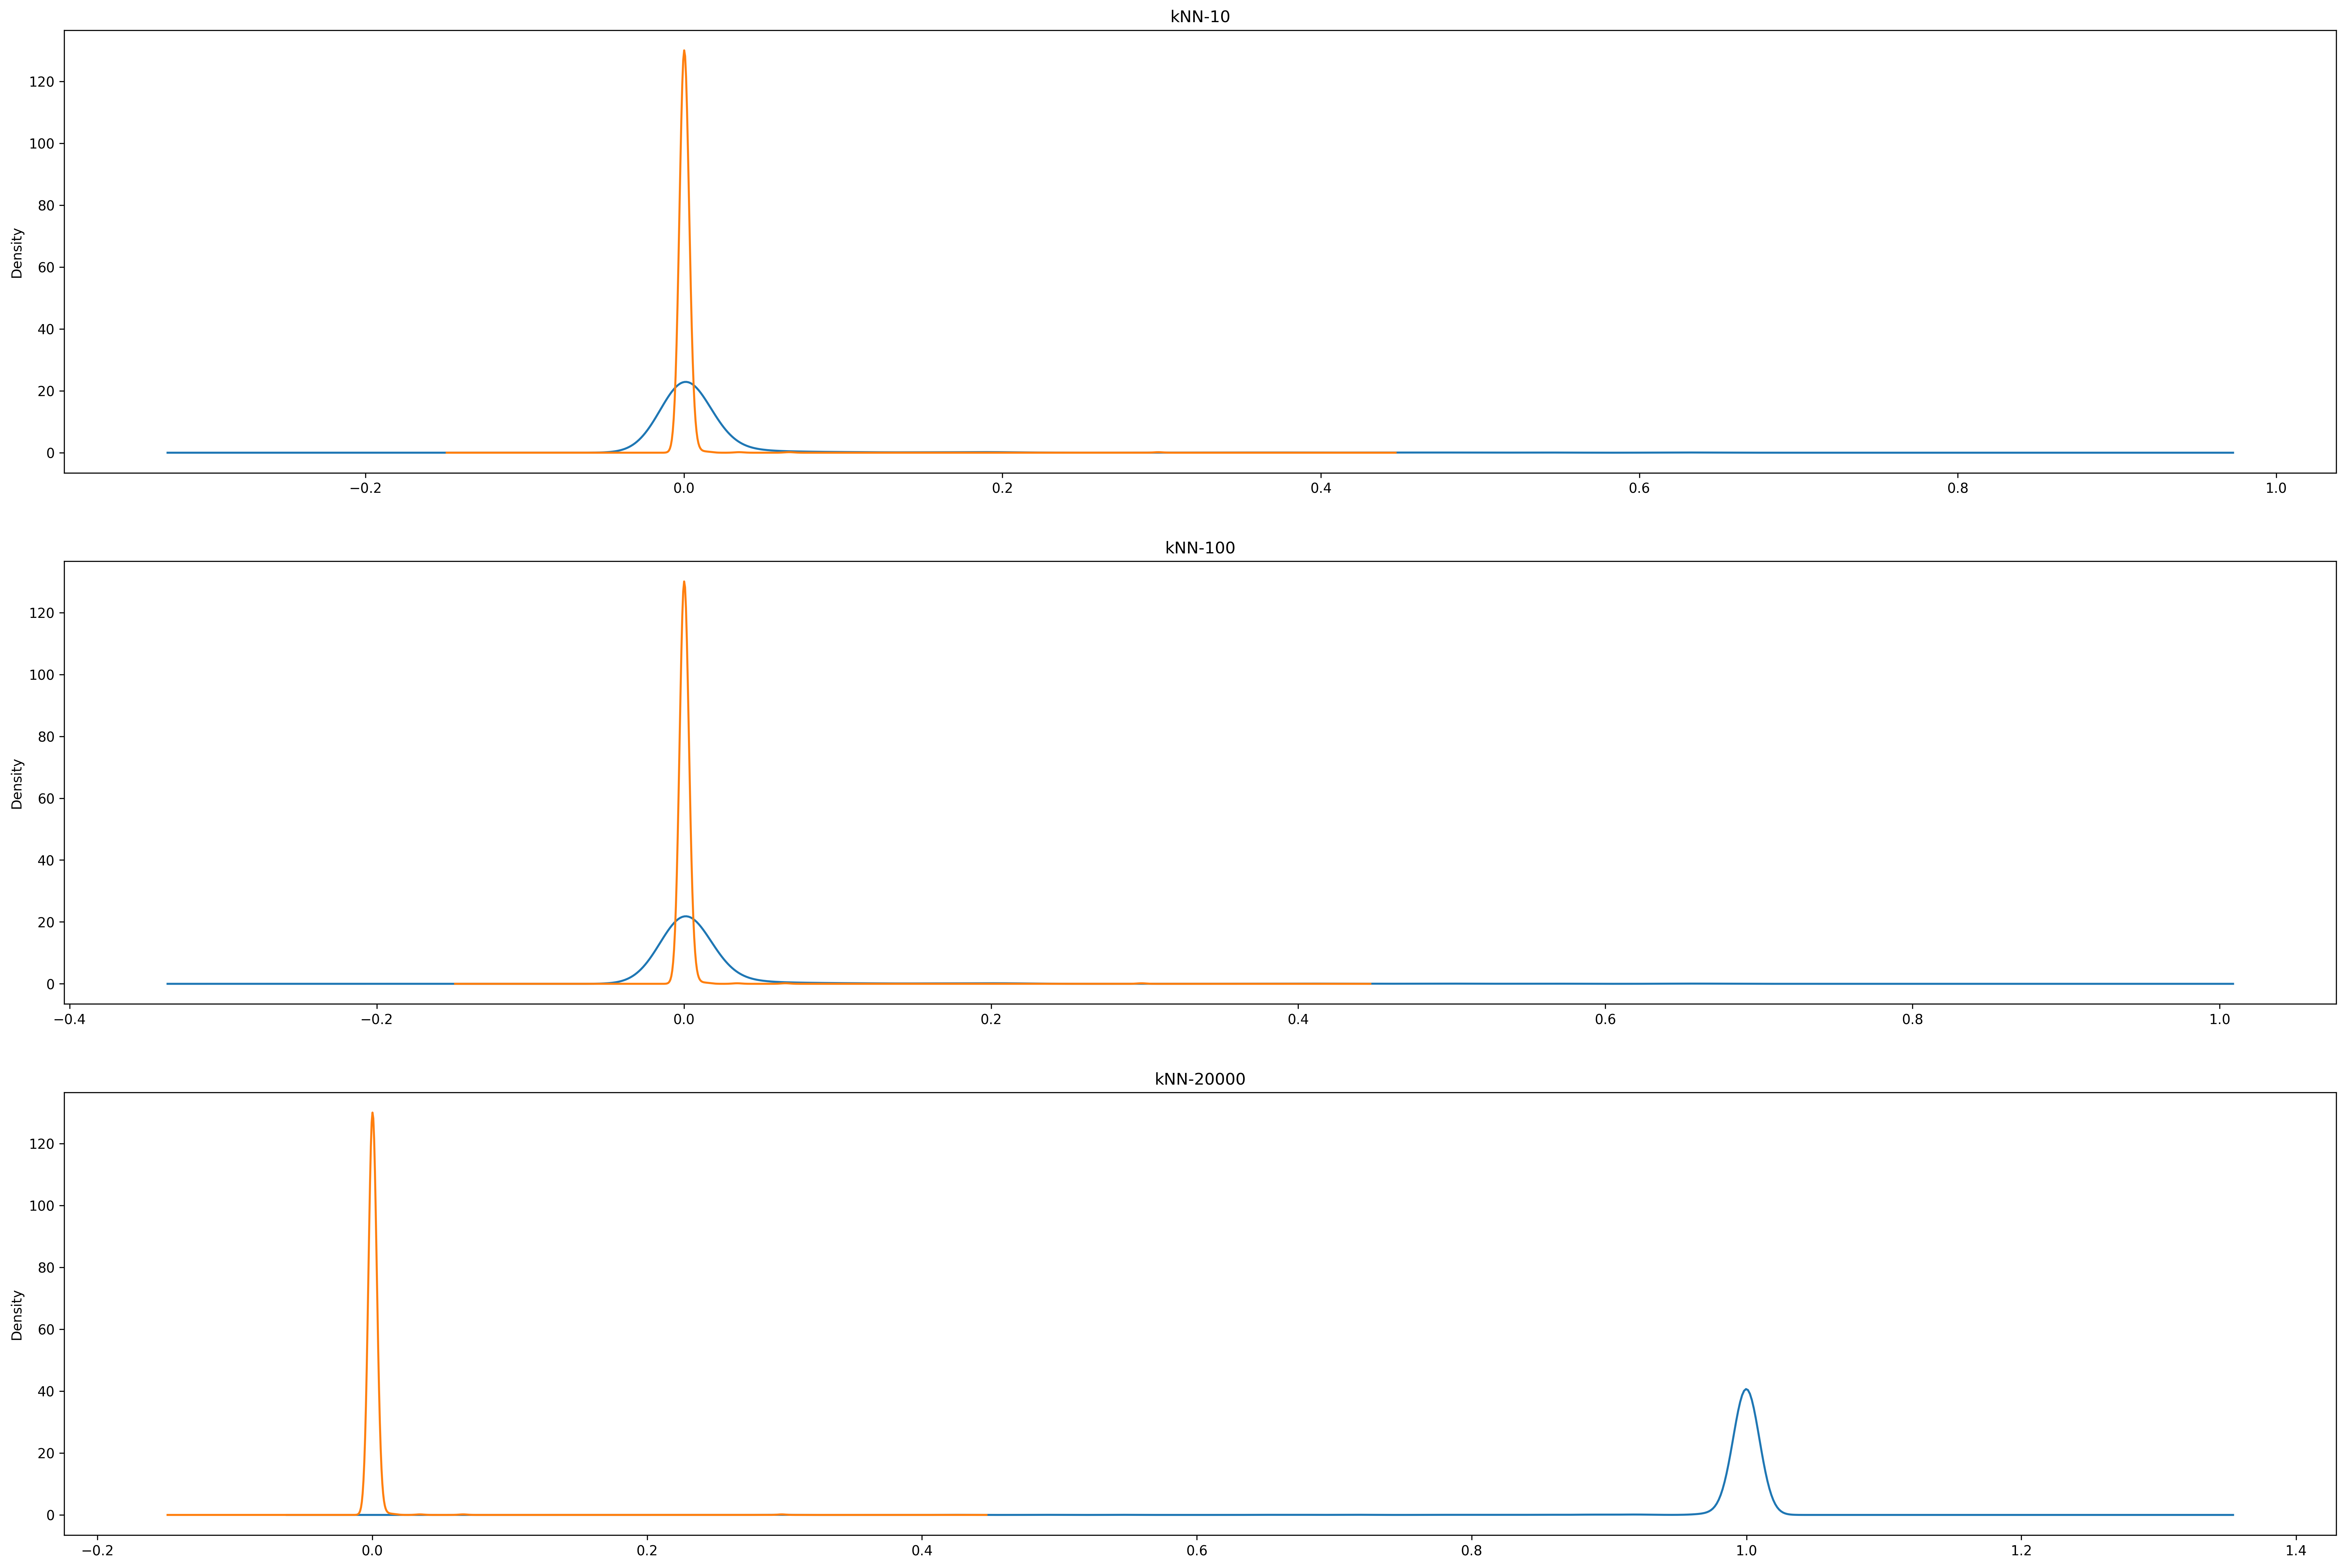

In [9]:
plot([
    seen_z_sample[seen_z_sample['class_00'] == 1.0], 
    seen_z_sample[seen_z_sample['class_00'] == 0.0],
],
    kind='density',
)

#### Mark the non Class-0 samples to use latter on

Seen:
[[ 763    0]
 [   1 1236]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       763
         1.0       1.00      1.00      1.00      1237

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



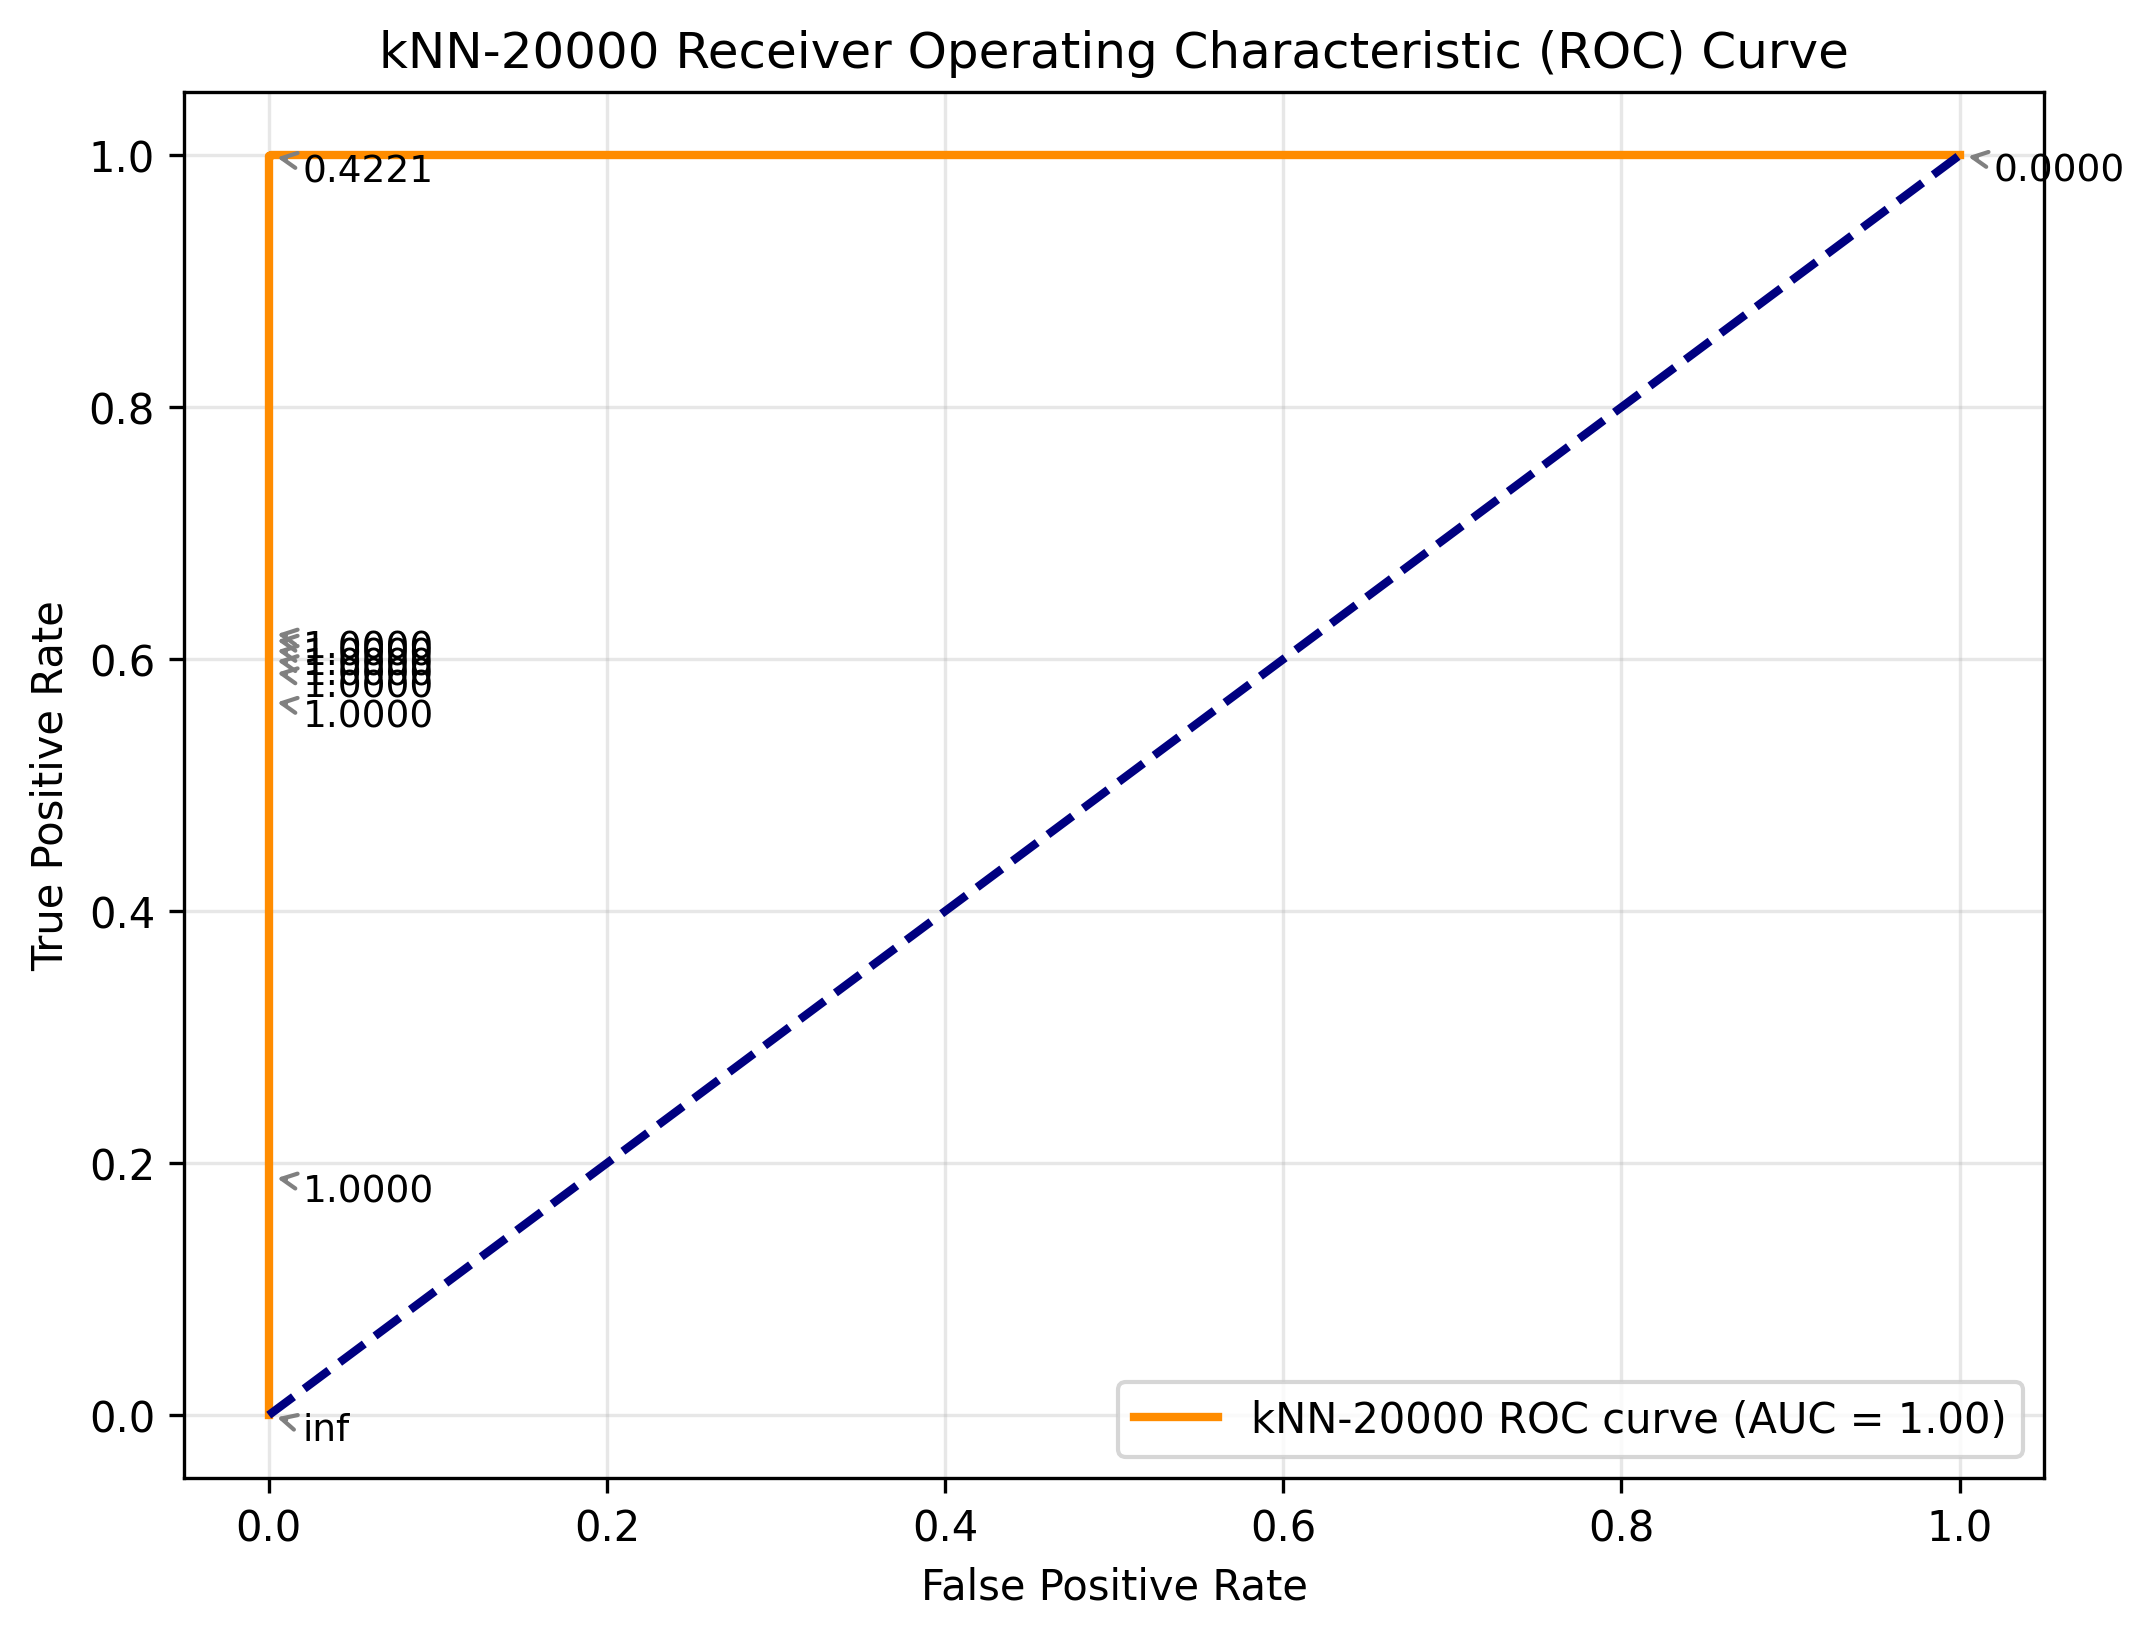

In [10]:
seen_z_sample['y_pred'] = 1.0
seen_z_sample.loc[seen_z_sample['kNN-20000'] < 0.30, 'y_pred'] = 0.0
print("Seen:")
print(confusion_matrix(seen_z_sample['class_00'].values, seen_z_sample['y_pred'].values))
print(classification_report(seen_z_sample['class_00'].values, seen_z_sample['y_pred'].values))
roc(seen_z_sample['class_00'], seen_z_sample, 'kNN-20000')


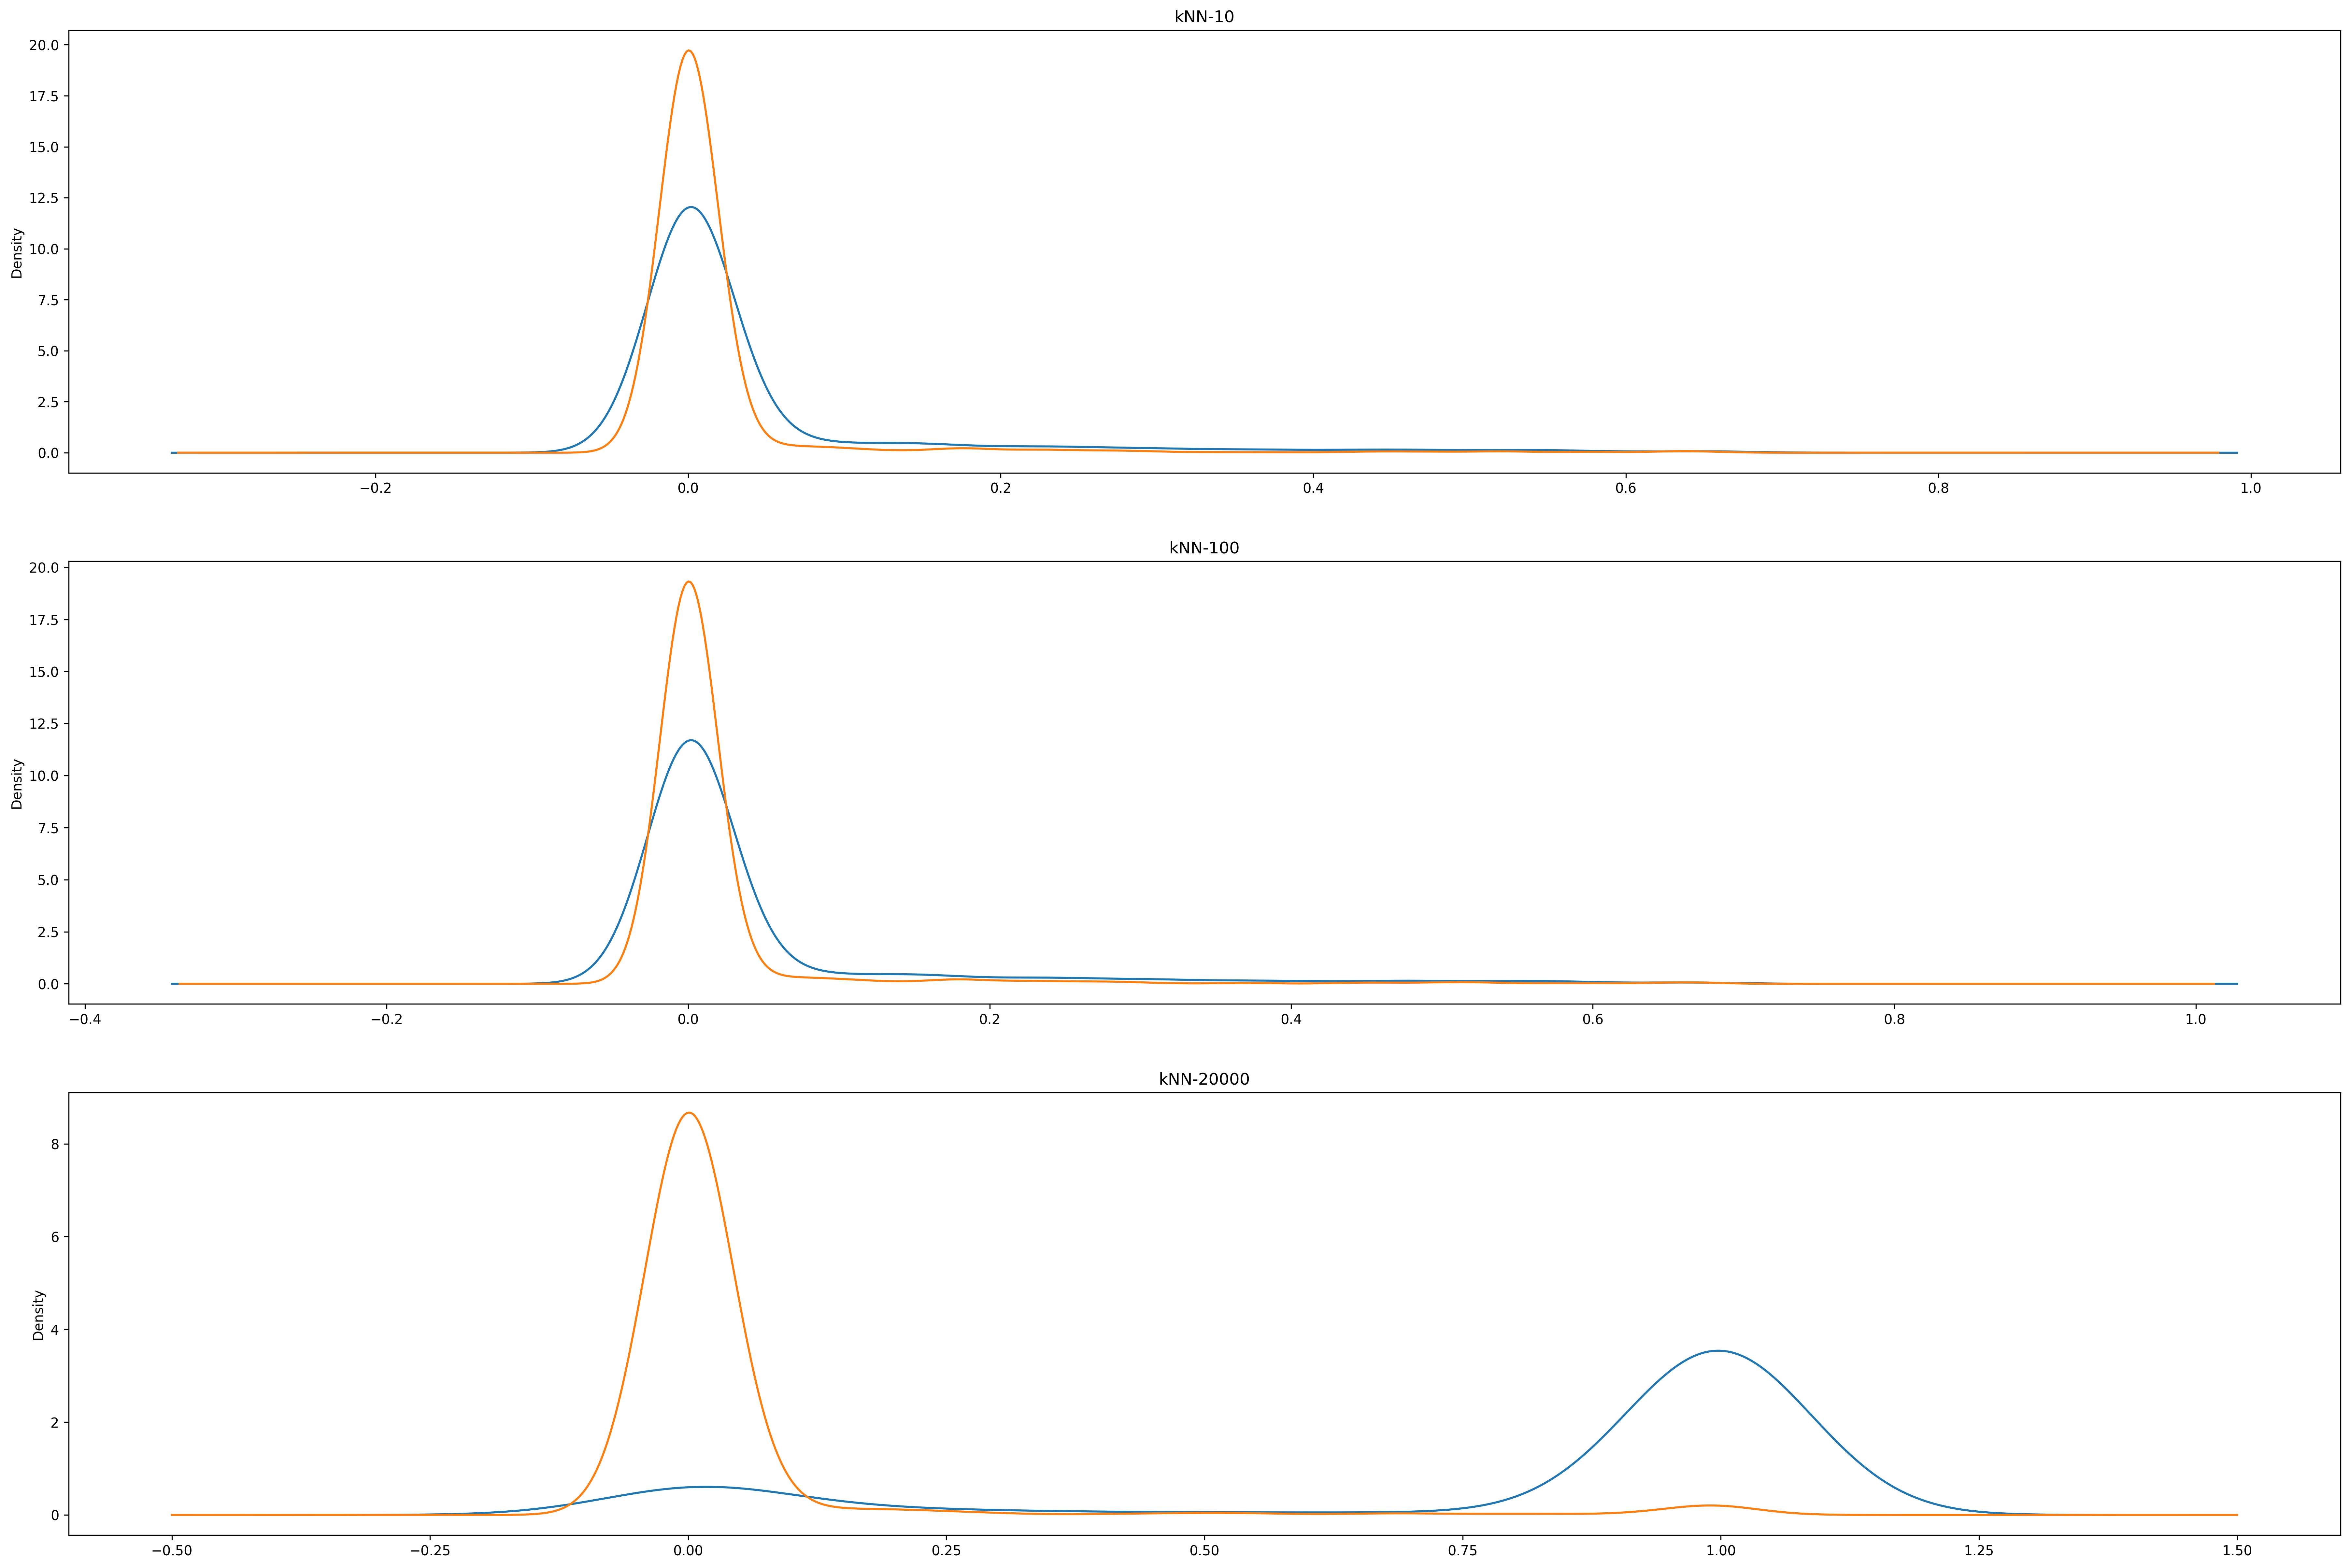

In [11]:
plot([
    uz[uz['class_00'] == 1.0], 
    uz[uz['class_00'] == 0.0],
],
    kind='density',
#     all=False
)

Unseen:
[[922  73]
 [121 884]]
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90       995
         1.0       0.92      0.88      0.90      1005

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



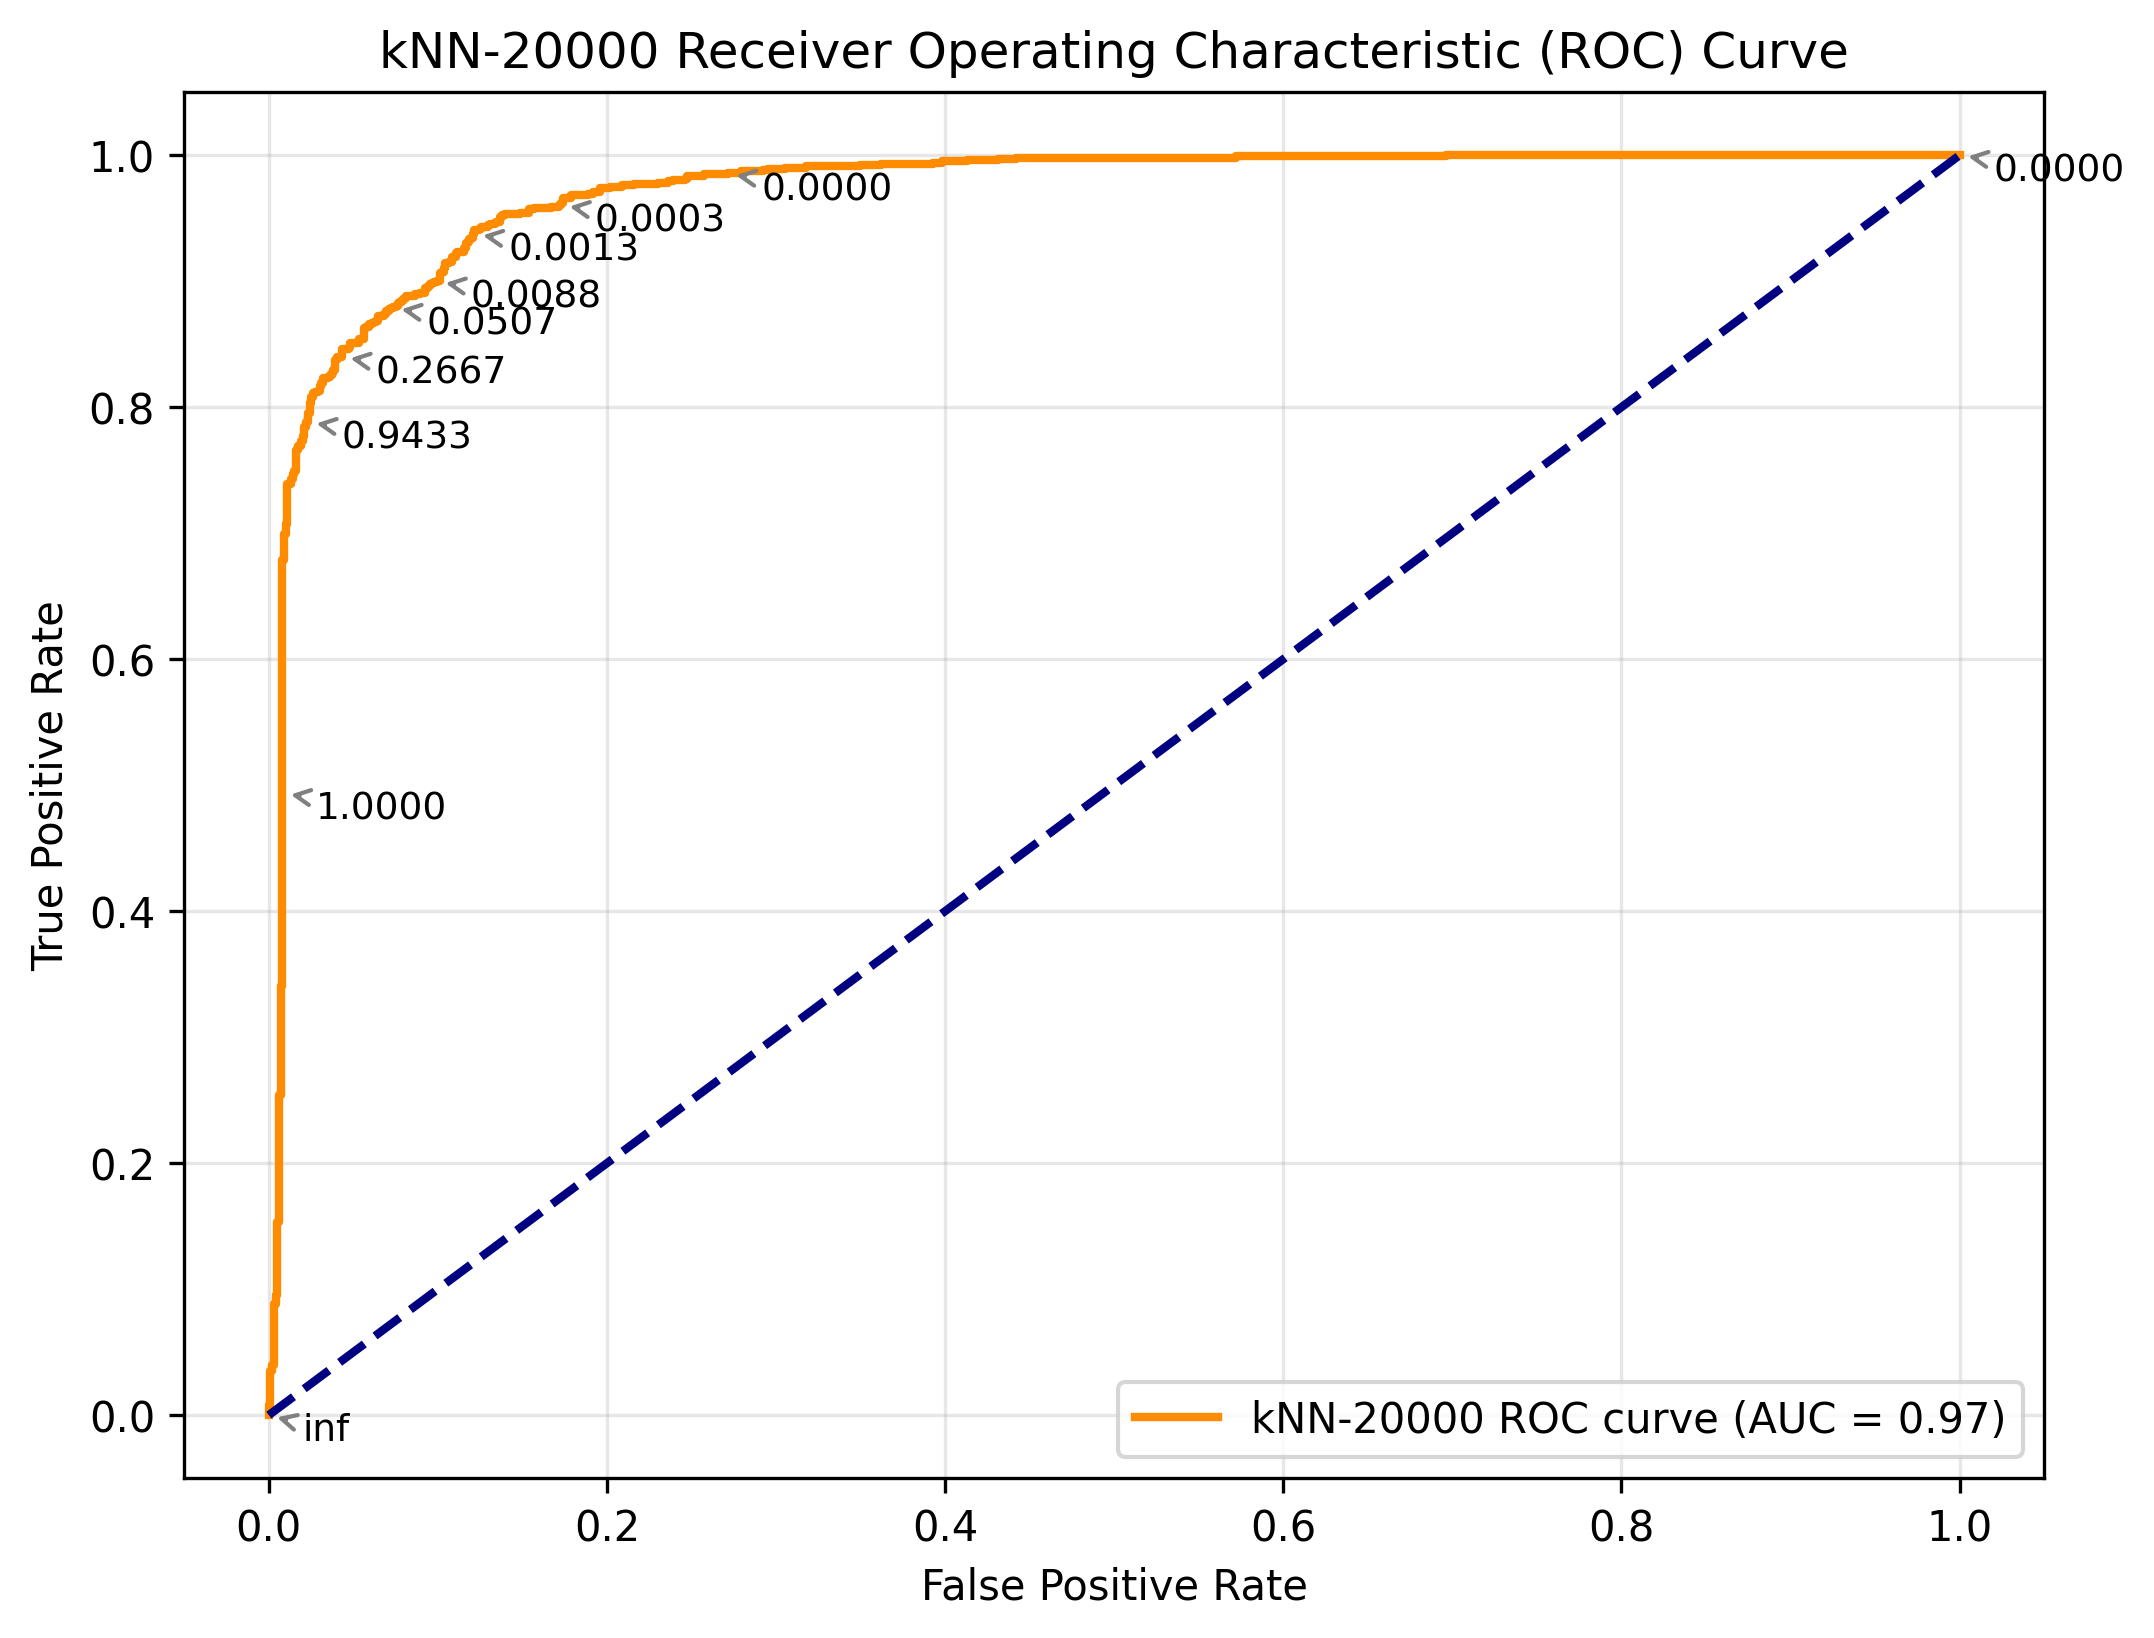

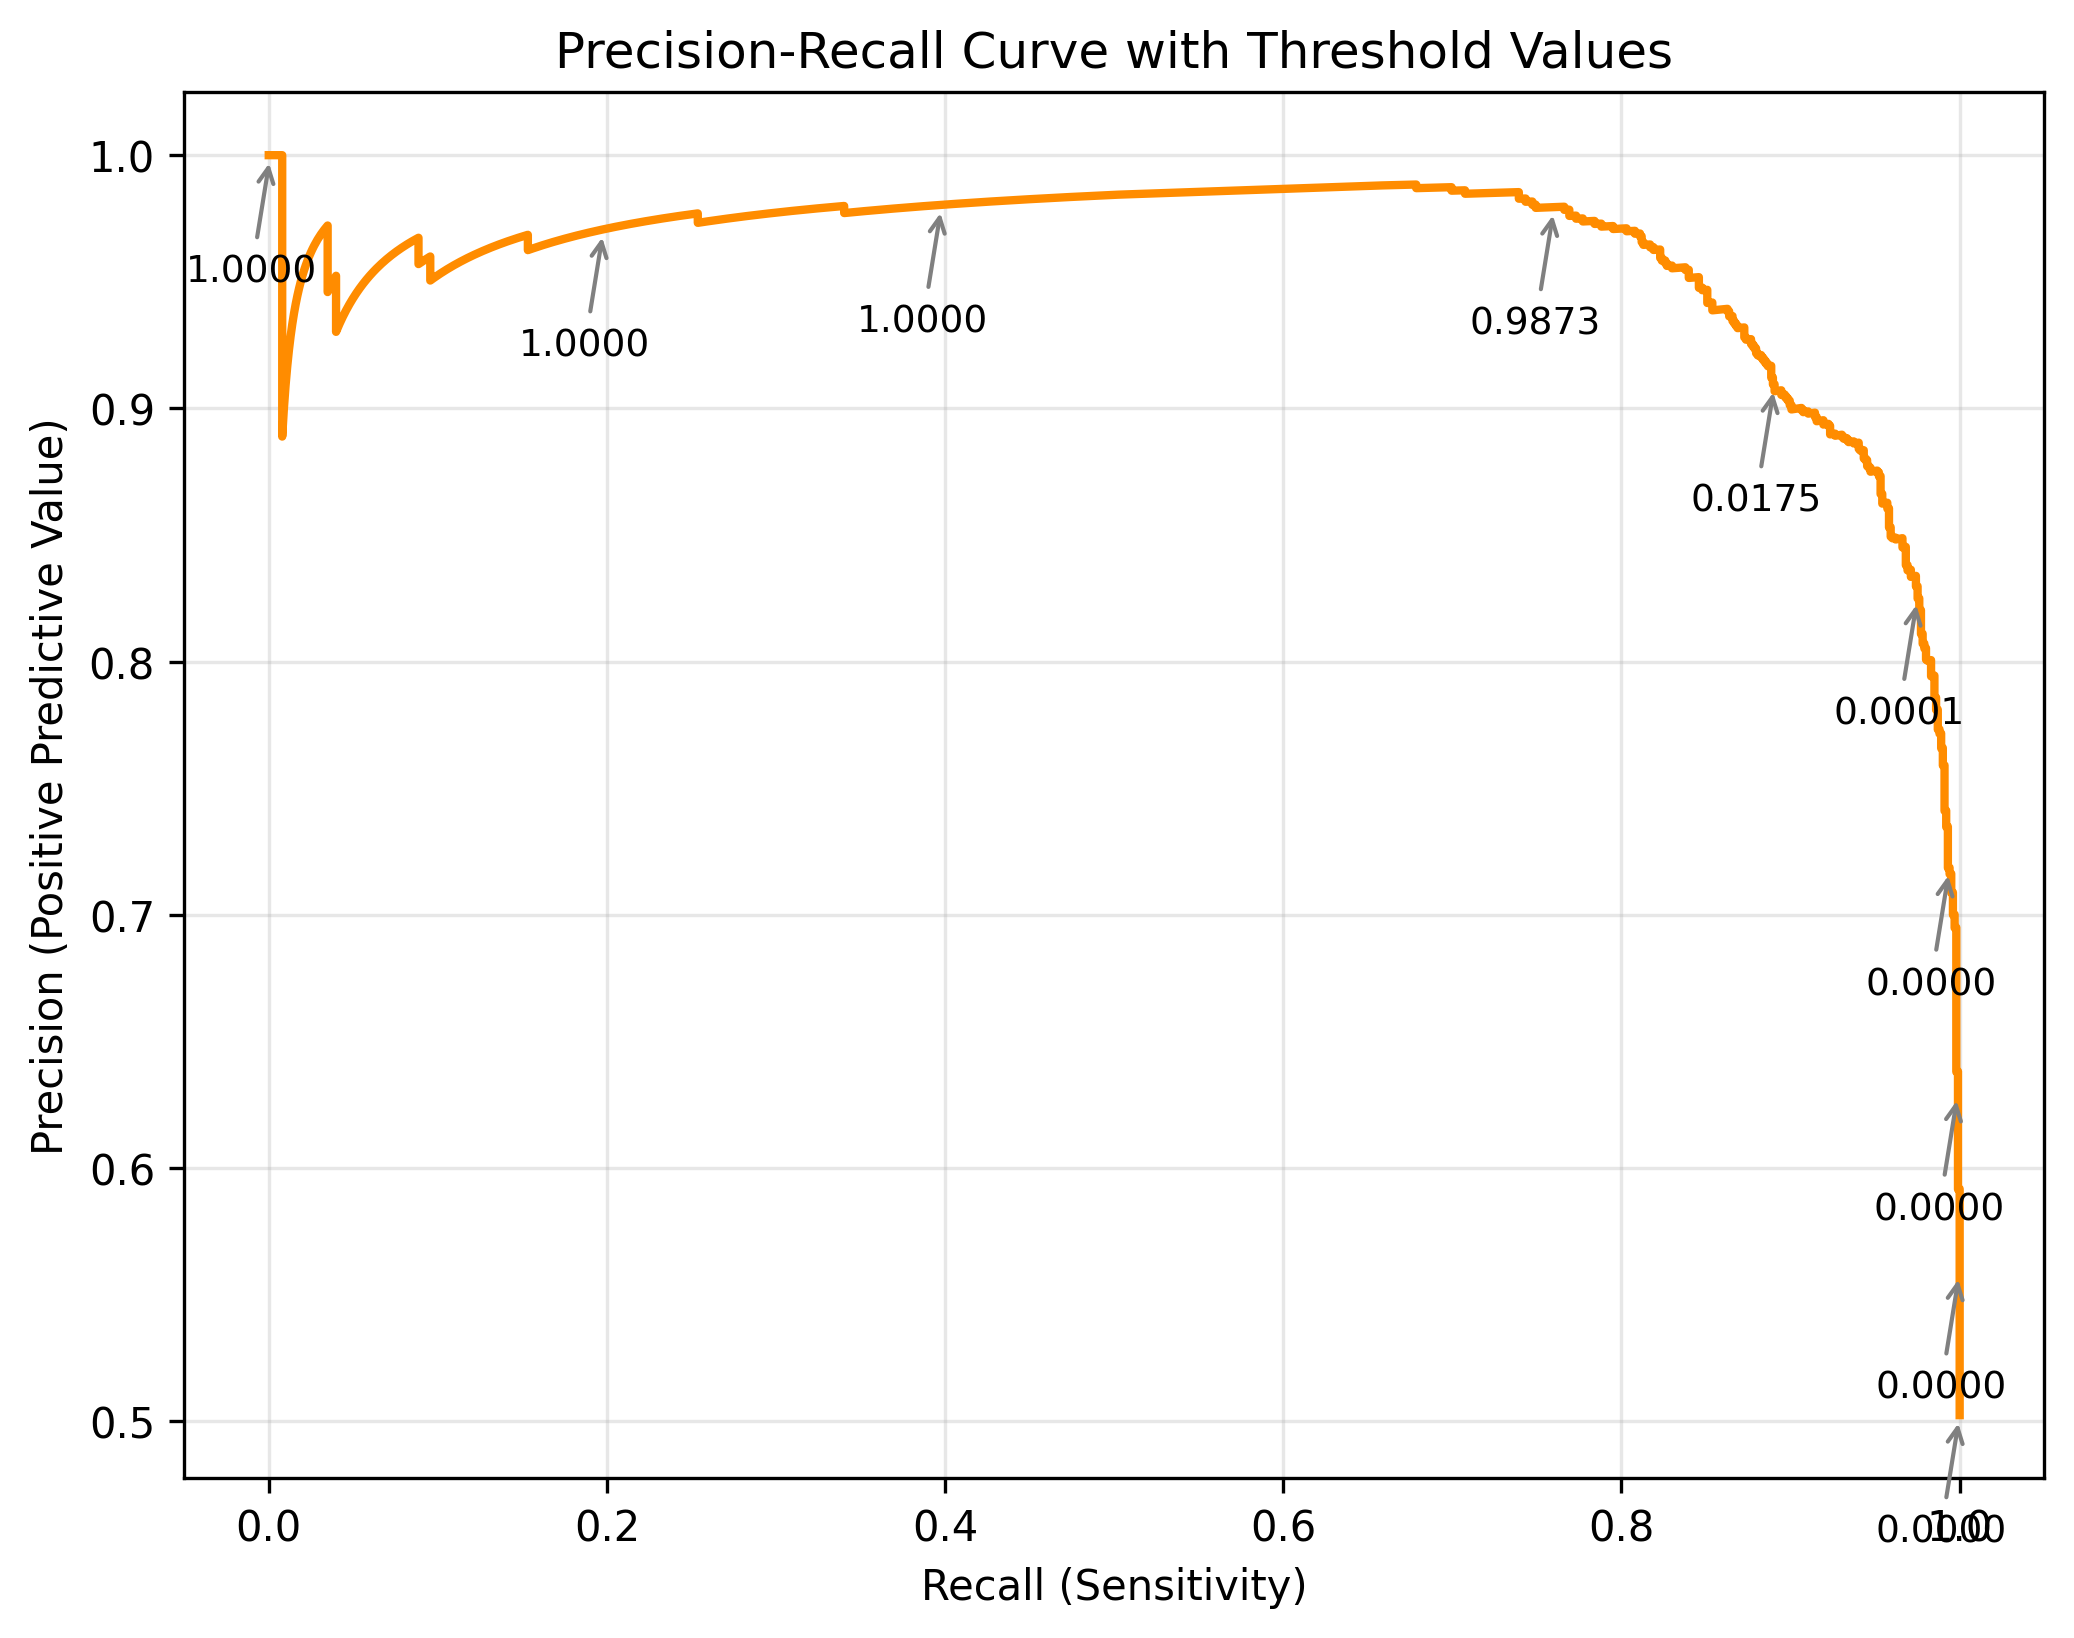

In [13]:
uz['y_pred'] = 1.0
uz.loc[uz['kNN-20000'] < 0.05, 'y_pred'] = 0.0
print("Unseen:")
print(confusion_matrix(uz['class_00'].values, uz['y_pred'].values))
print(classification_report(uz['class_00'].values, uz['y_pred'].values))
uzn = uz.fillna(1.0)
roc(uzn['class_00'], uzn, 'kNN-20000')
prc(uzn['class_00'], uzn['kNN-20000'].values)
uz['IsClass0'] = uz['y_pred']


### 'class_0' is not used anymore
#### Normalize data with the L2 norm (without the 'class_0' columns)

In [14]:
seen_z = seen_z.drop(columns=nxc).drop(columns=['norm'])
# uz = uz.drop(columns=nxc).drop(columns=['norm'])
uz = unseen_z.copy()

xc = [
           '1',  '2',  '3',  '4',  '5',  '6',  '7',  '8',  '9', 
    '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
    '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', 
    '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 
    '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 
    '50', '51', '52', '53'
     ]
nxc = [
            'n1',  'n2',  'n3',  'n4',  'n5',  'n6',  'n7',  'n8',  'n9', 
    'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 
    'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29', 
    'n30', 'n31', 'n32', 'n33', 'n34', 'n35', 'n36', 'n37', 'n38', 'n39', 
    'n40', 'n41', 'n42', 'n43', 'n44', 'n45', 'n46', 'n47', 'n48', 'n49', 
    'n50', 'n51', 'n52', 'n53'
      ]

norm = seen_z[xc].apply(linalg.norm, axis=1)
seen_z['norm'] = norm
norm = seen_z[xc].apply(lambda x: x/seen_z['norm'])
seen_z[nxc] = norm[xc]

norm = uz[xc].apply(linalg.norm, axis=1)
uz['norm'] = norm
norm = uz[xc].apply(lambda x: x/uz['norm'])
uz[nxc] = norm[xc]

### Test set with equal seen in unseen, no Negative samples
#### Calculate kNNs over a Base of only the Positive samples, sample the input due to n^2 complexity of algorithm

In [16]:
tmp = seen_z[seen_z['class_00'] == 0.0].sample(len(uz[uz['class_00'] == 0.0]), random_state=(random_seed+1), ignore_index=True)
unseenz = pd.concat([uz[uz['class_00'] == 0.0], tmp]).reset_index(drop=True)
uz2c = calculate_kNN(seen_z[seen_z['class_00'] == 0.0], 
                     unseenz,
                     '', nxc, 
                    )
seen_z_sample = calculate_kNN(seen_z[seen_z['class_00'] == 0.0], 
                              seen_z[seen_z['class_00'] == 0.0].sample(len(uz2c), random_state=random_seed, ignore_index=True, replace=True), 
                              '', nxc, 
                             )

100% (1000 of 1000) |####################| Elapsed Time: 0:00:52 Time:  0:00:520:26


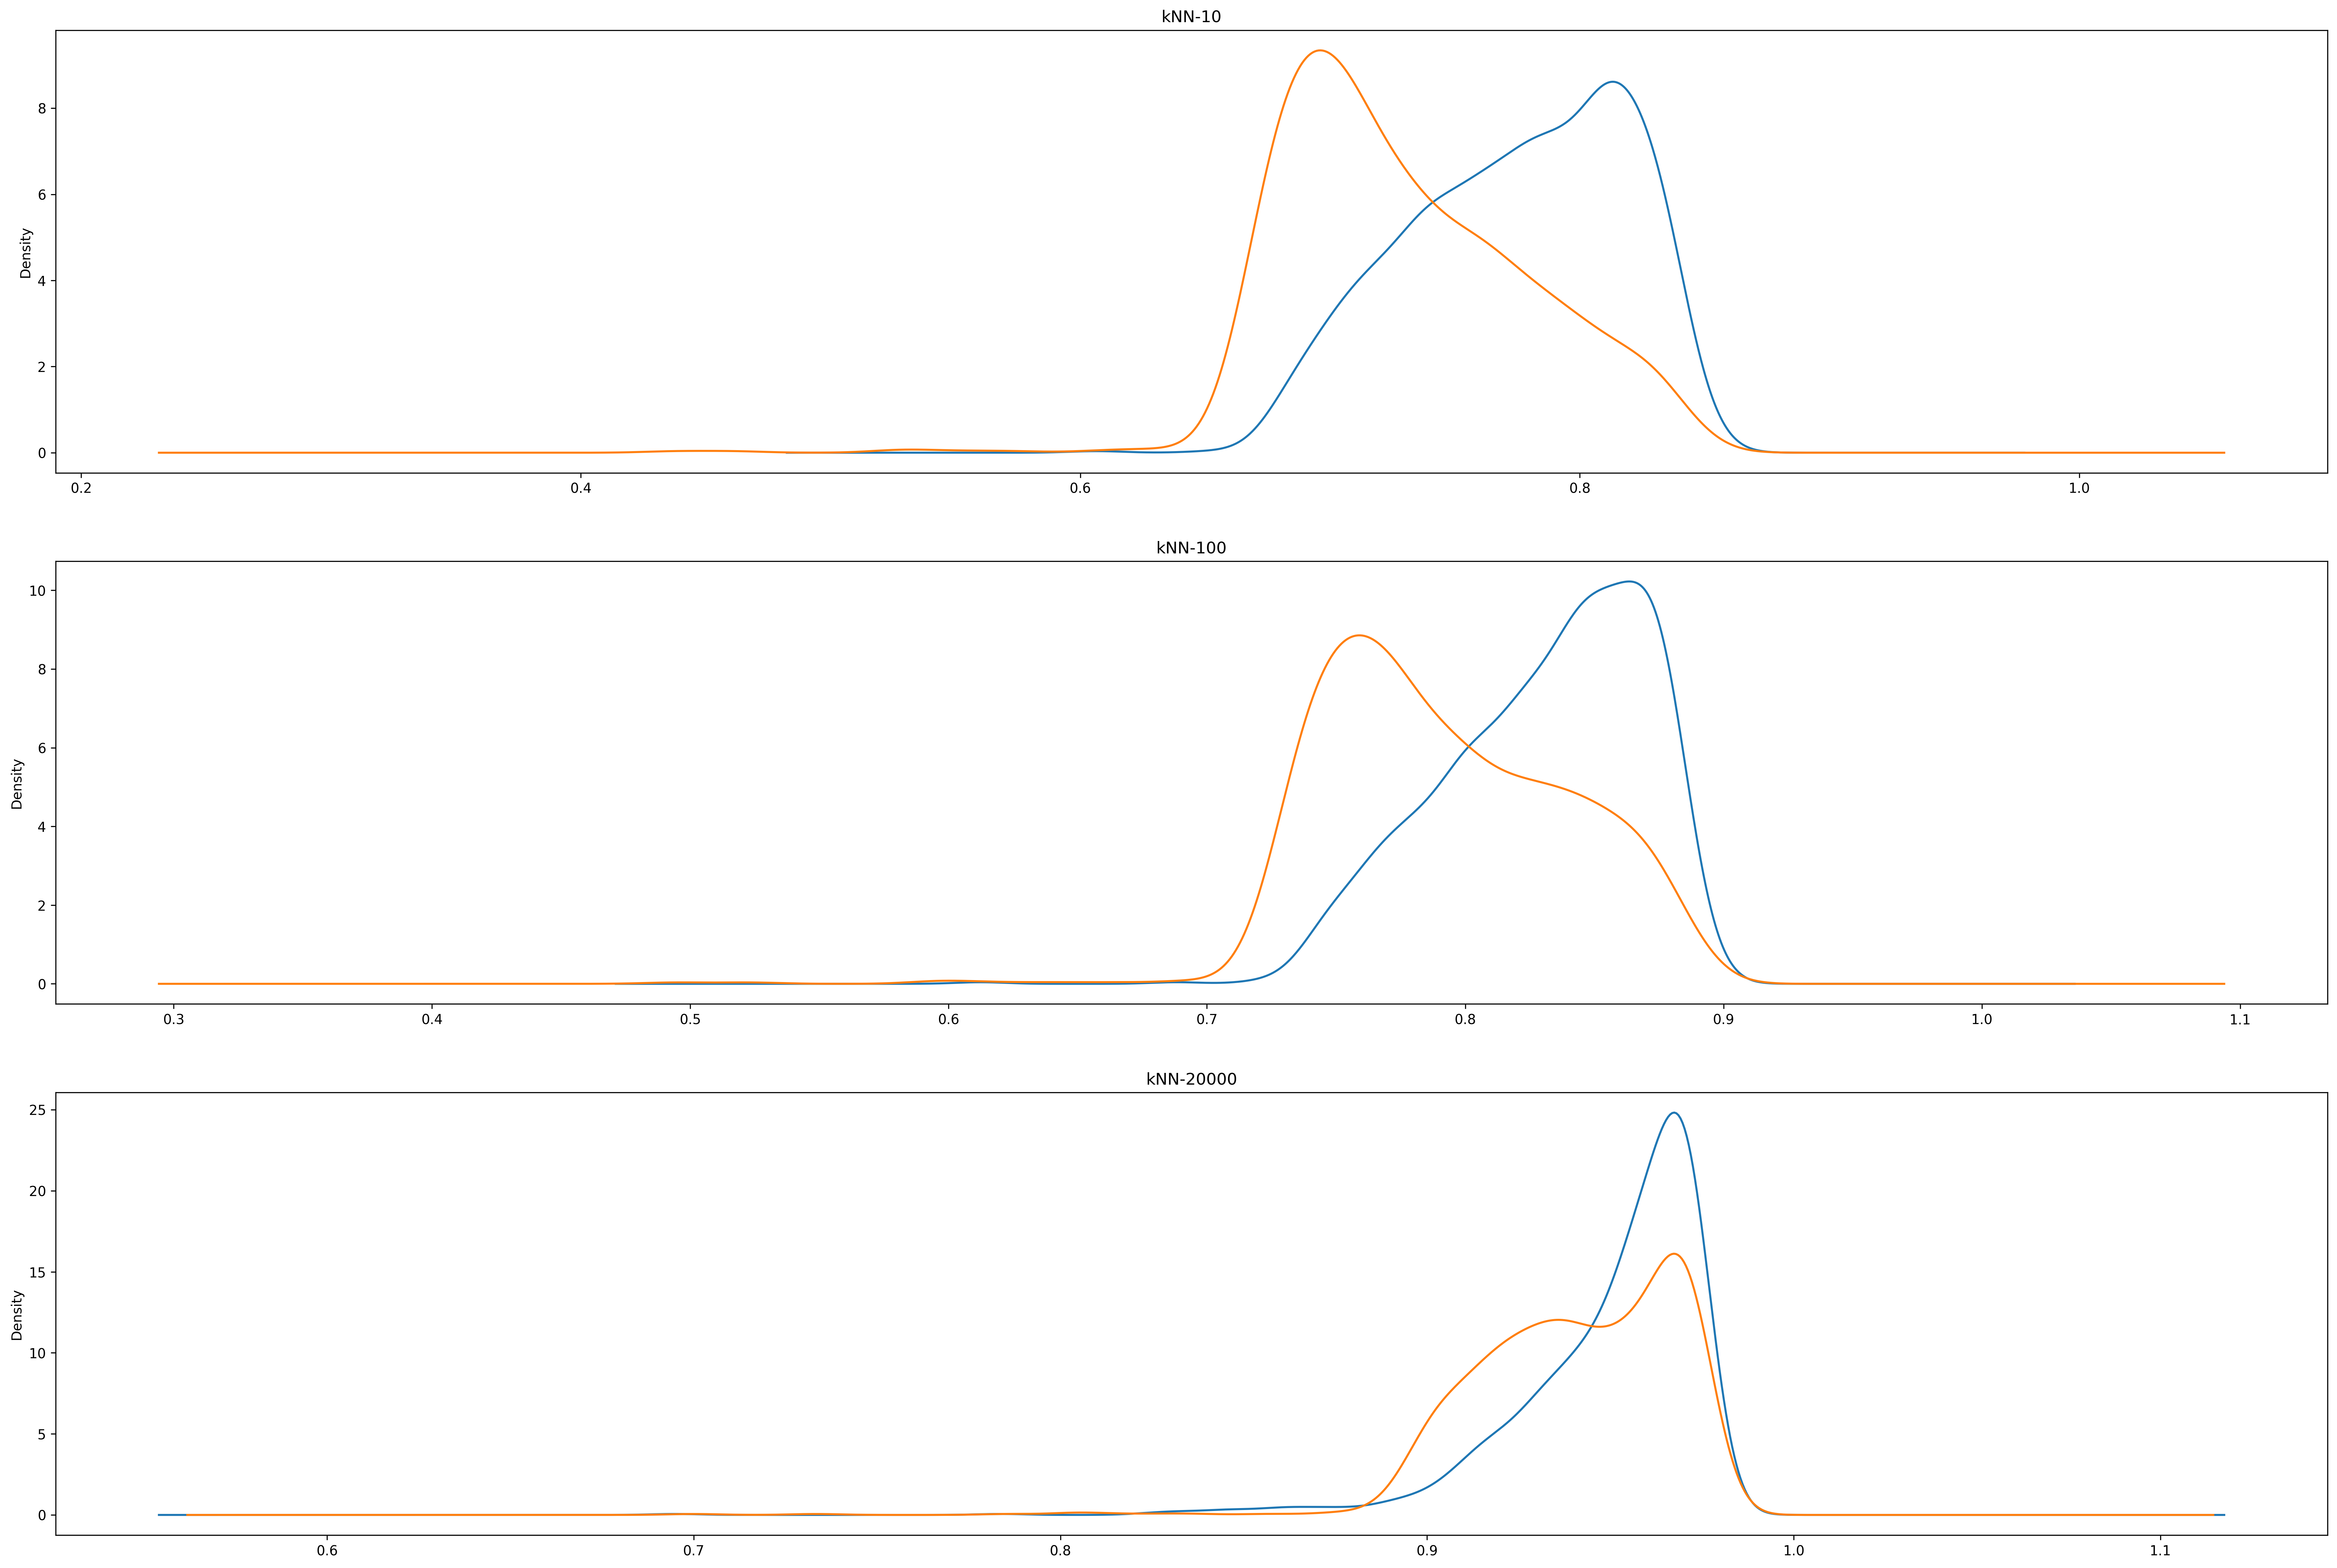

In [17]:
plot([
    uz2c[uz2c['InD'] == 1.0],
    uz2c[uz2c['InD'] == 0.0],
],
     kind='density',
#     all=True
)

[[644 340]
 [277 739]]
              precision    recall  f1-score   support

         0.0       0.70      0.65      0.68       984
         1.0       0.68      0.73      0.71      1016

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000



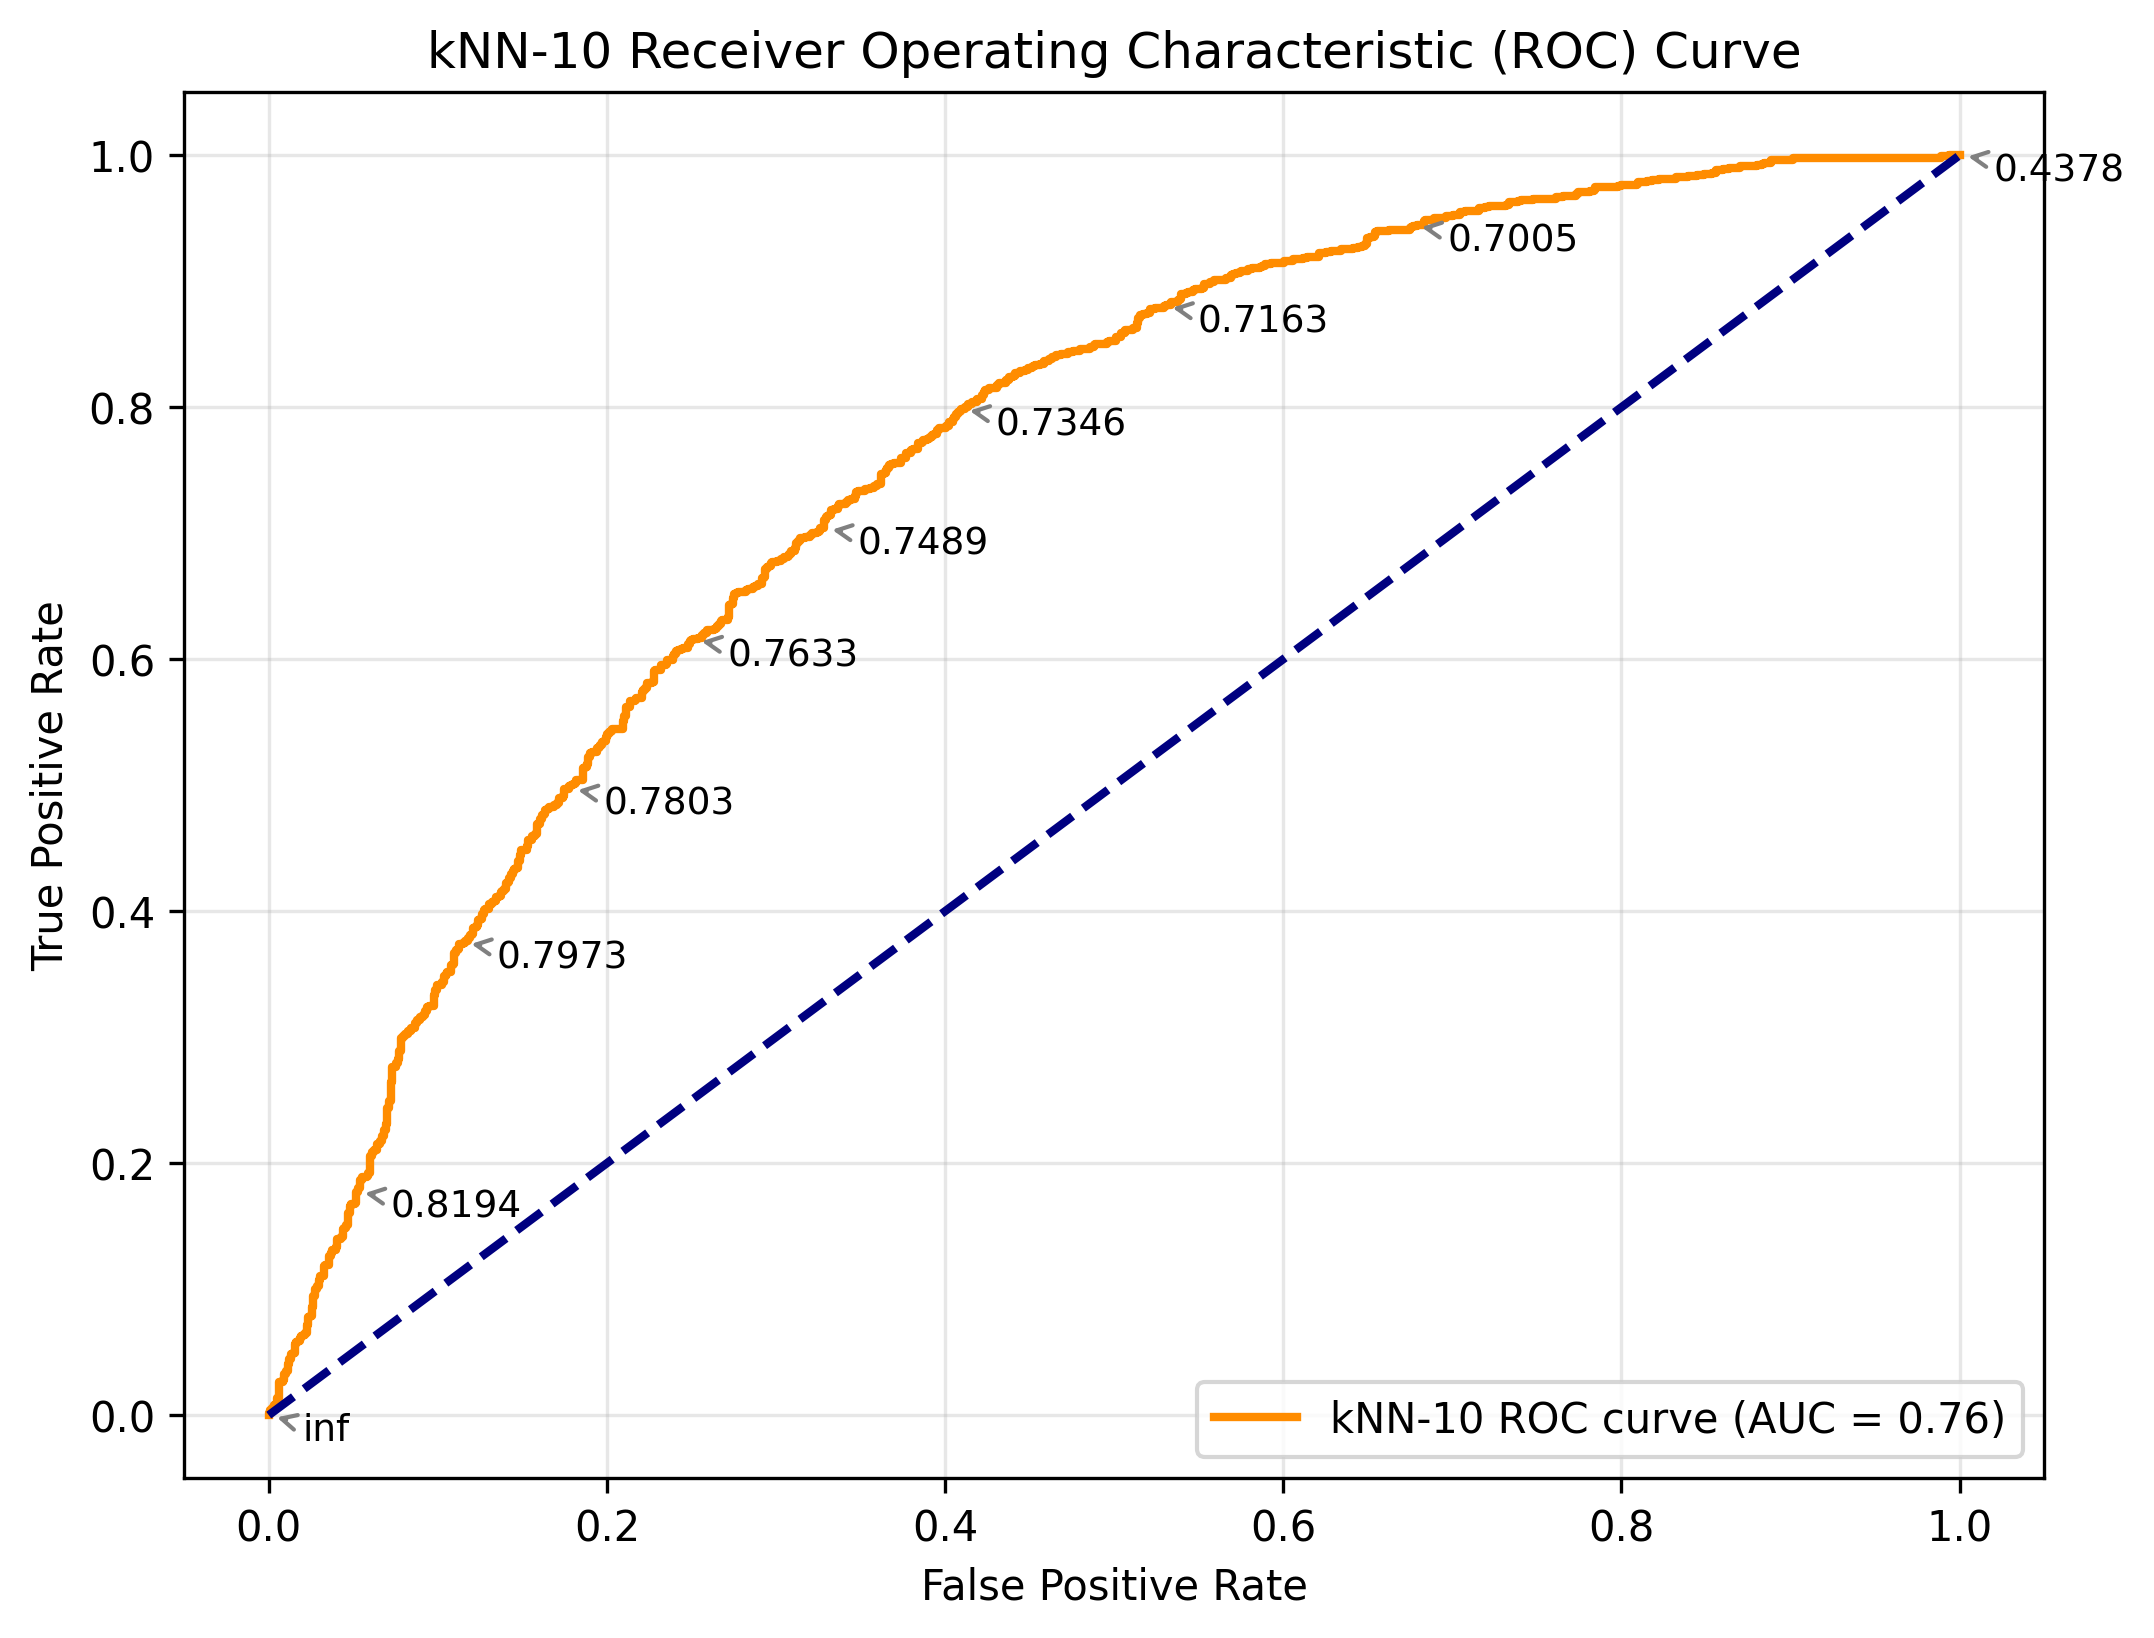

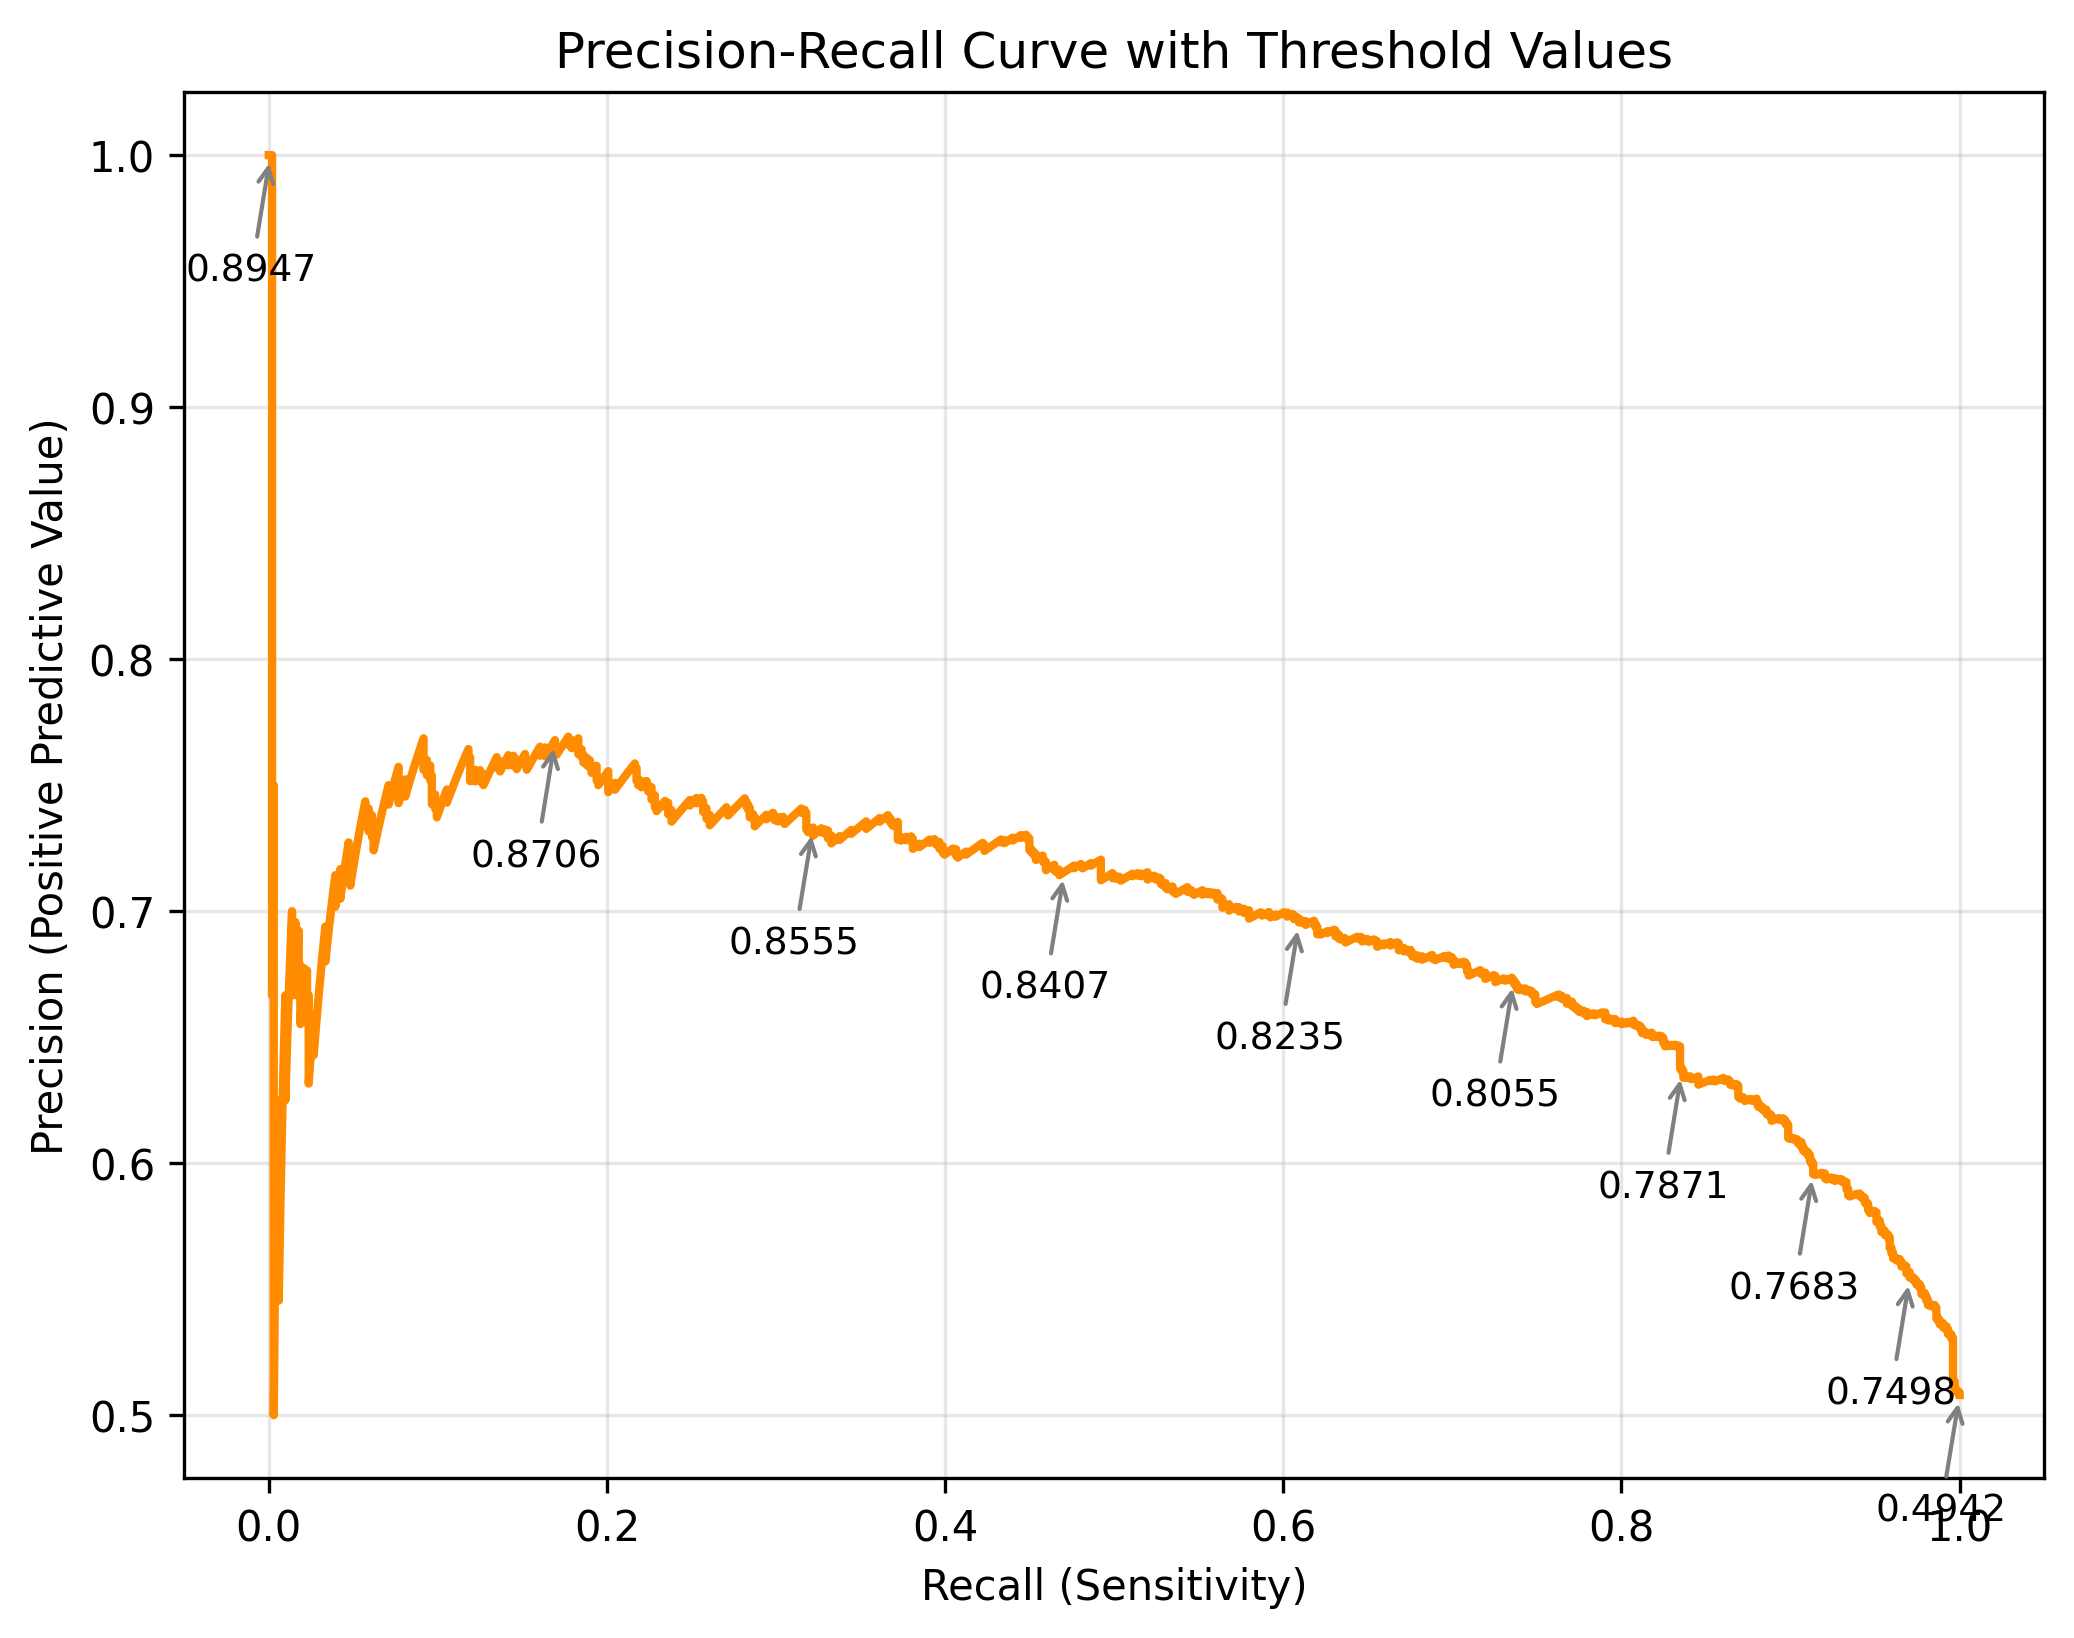

class_18
[[637 330]
 [277 739]]
              precision    recall  f1-score   support

         0.0       0.70      0.66      0.68       967
         1.0       0.69      0.73      0.71      1016

    accuracy                           0.69      1983
   macro avg       0.69      0.69      0.69      1983
weighted avg       0.69      0.69      0.69      1983

class_45
[[644 340]
 [277 739]]
              precision    recall  f1-score   support

         0.0       0.70      0.65      0.68       984
         1.0       0.68      0.73      0.71      1016

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000



In [19]:
uz2c['y_pred'] = 1.0
uz2c.loc[(uz2c['kNN-10'] < 0.745), 'y_pred'] = 0.0
print(confusion_matrix(uz2c['InD'].values, uz2c['y_pred'].values))
print(classification_report(uz2c['InD'].values, uz2c['y_pred'].values))
roc(uz2c['InD'].values, uz2c, 'kNN-10')
prc(uz2c['InD'].values, uz2c['kNN-100'].values)
for column in ['class_18', 'class_45']:
    print(column)
    print(confusion_matrix(uz2c[uz2c[column] == 1.0]['InD'].values, uz2c[uz2c[column] == 1.0]['y_pred'].values))
    print(classification_report(uz2c[uz2c[column] == 1.0]['InD'].values, uz2c[uz2c[column] == 1.0]['y_pred'].values))    